In [1]:
# checking os
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))


Linux-6.6.56+-x86_64-with-glibc2.35


In [2]:
#Dataset path

PROJECT_DIR = '/kaggle/input/real-life-violence-situations-dataset'

In [3]:
#Data agumentation on pre processsing data
import cv2
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 120
ColorChannels = 3

# Albumentations Augmentation Pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.CLAHE(p=0.2),
])

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    count = 0
    ImageFrames = []

    while vidcap.isOpened():
        ID = vidcap.get(1)  # Frame ID
        success, image = vidcap.read()

        if success:
            # Skipping frames to avoid duplications
            if ID % 7 == 0:
                # Apply Albumentations augmentation
                augmented = transform(image=image)["image"]

                # Convert BGR to RGB before resizing
                rgb_img = cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))

                ImageFrames.append(resized)
                count += 1
        else:
            break

    vidcap.release()
    return ImageFrames


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:230: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [4]:
# dataset path cross checking
import os
VideoDataDir = "/kaggle/input/real-life-violence-situations-dataset"
print(os.listdir(VideoDataDir))  # List all folders inside the dataset

['real life violence situations', 'Real Life Violence Dataset']


In [5]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violent videos \n{} non violent videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []


CLASSES = ["NonViolence", "Violence"]


for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:800])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violent videos 
1000 non violent videos


100%|██████████| 800/800 [03:31<00:00,  3.78it/s]

CPU times: user 12min 22s, sys: 1min 59s, total: 14min 21s
Wall time: 4min 59s


In [6]:
X_original = np.array(X_original)  # Keeping original shape (batch, height, width, channels)
y_original = np.array(y_original)


# checking no of sample
len(X_original)

33396

In [7]:
# Dataset Splitting using Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
stratified_sample = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=73)
for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

# Normalize Data
X_train_nn = X_train / 255.0
X_test_nn = X_test / 255

In [8]:
!pip install imutils
clear_output()

In [10]:
# importing libraires
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

In [11]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, LSTM, TimeDistributed, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime

In [13]:
#Hyperparameter Initialization

IMG_SIZE = 120
ColorChannels = 3
epochs = 50
patience = 3
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 16
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
kernel_regularizer = regularizers.l2(0.0003)

In [14]:
# Load Model with LSTM
def load_model():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, x.shape[-1]))(x)  # Reshape to 3D tensor for LSTM
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = load_model()

<ipython-input-14-c7926920566e>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 120, 120, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 60, 60, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 60, 60, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 60, 60, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 60, 60, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 60, 60, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 60, 60, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 60, 60, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 60, 60, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 60, 60, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 60, 60, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 60, 60, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 61, 61, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 30, 30, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,606,529 (9.94 MB)

 Trainable params: 348,545 (1.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
checkpoint_filepath = './best_model.weights.h5'
def lrfn(epoch):
    if epoch < 5:
        return (0.00005 - 0.00001) / 5 * epoch + 0.00001
    else:
        return (0.00005 - 0.00001) * 0.8**(epoch - 5) + 0.00001

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.999:
            print("\nLimits Reached, cancelling training!")
            self.model.stop_training = True

callbacks = [
    myCallback(),
    LearningRateScheduler(lrfn, verbose=True),
    ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1, min_delta=0.00075),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
]


In [16]:
# Training the Model
print('Training Model...')
history = model.fit(X_train_nn, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_nn, y_test), callbacks=callbacks)

print('\nRestoring best weights for MobileNetV2 + LSTM')
model.load_weights(checkpoint_filepath)

Training Model...

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5368 - loss: 0.7098
Epoch 1: val_loss improved from inf to 0.63362, saving model to ./best_model.weights.h5
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.5369 - loss: 0.7098 - val_accuracy: 0.6999 - val_loss: 0.6336 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/50
1459/1462 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6790 - loss: 0.6244
Epoch 2: val_loss improved from 0.63362 to 0.50138, saving model to ./best_model.weights.h5
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.6791 - loss: 0.6243 - val_accuracy: 0.8014 - val_loss: 0.5014 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/50
1461/1462 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7707 - loss: 0.5158
Epoch 3: va

In [17]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30) 

------------------------------------------------------------------------------------------
Best Epochs:  33
Accuracy on train: 0.9511913657188416 	Loss on train: 0.14584754407405853
Accuracy on test: 0.936221182346344 	Loss on test: 0.18665364384651184


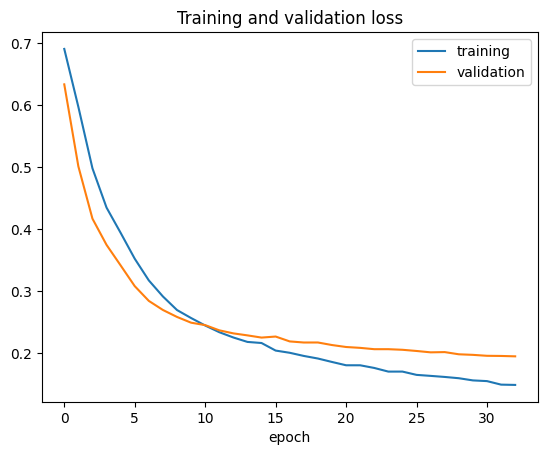

<Figure size 640x480 with 0 Axes>

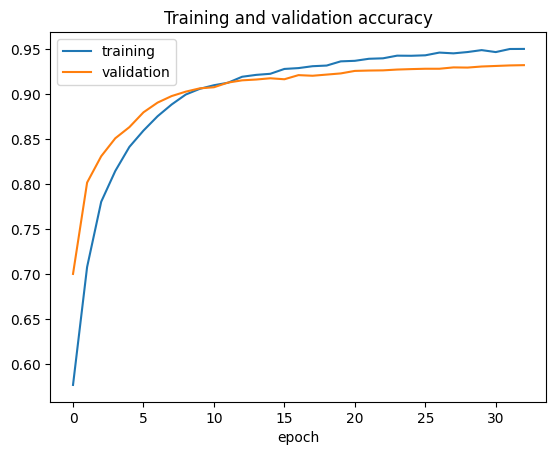

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [18]:
model_summary(model, history)

In [19]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


> Correct Predictions: 9380
> Wrong Predictions: 639


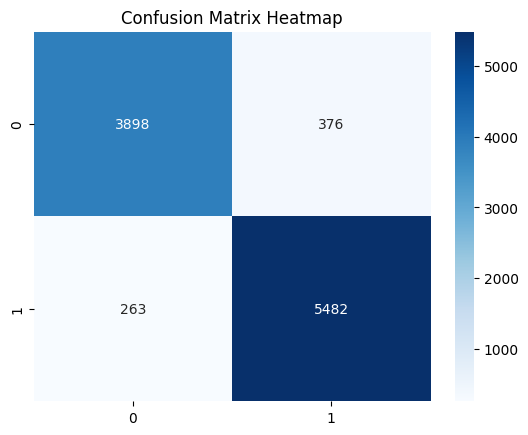

              precision    recall  f1-score   support

 NonViolence       0.94      0.91      0.92      4274
    Violence       0.94      0.95      0.94      5745

    accuracy                           0.94     10019
   macro avg       0.94      0.93      0.93     10019
weighted avg       0.94      0.94      0.94     10019



In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, accuracy_score, classification_report, confusion_matrix

# Confusion Matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + corr_pred[1][0]))
print('> Wrong Predictions:', n_wrongs)

# Heatmap for Confusion Matrix
sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Classification Report
print(metrics.classification_report(y_test, preds, target_names=["NonViolence", "Violence"]))




In [22]:
from sklearn.metrics import roc_curve, auc

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


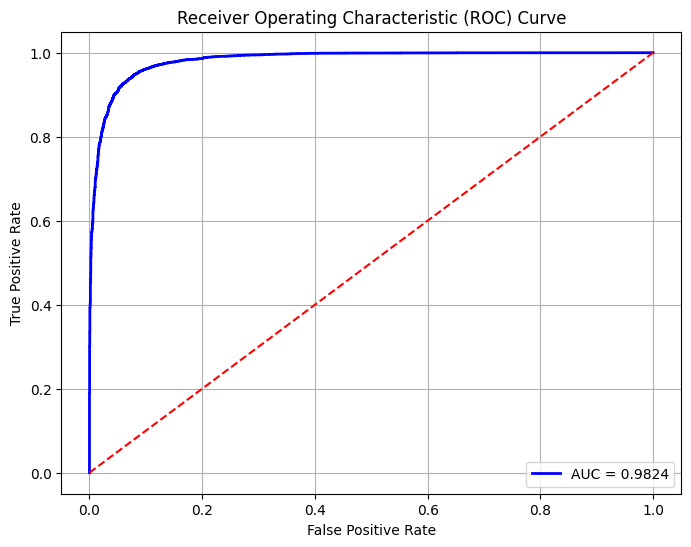

AUC Score: 0.9824379442480755


In [23]:
y_pred_prob = model.predict(X_test_nn)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  # Use y_pred_prob (probabilities) here
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("AUC Score:", roc_auc)


In [24]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, preds)
print("MCC Score:", mcc)

MCC Score: 0.8694219713864227


In [ ]:
args_model = "RLVDS 800vid .h5"
model.save(args_model)